In [1]:
import pandas as pd
import praw
from praw.models import MoreComments
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import defaultdict
import spacy
import string
import re

C:\Users\sed\anaconda3\envs\nlp_course\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
ci = "TTvdII1Rg7IzUg" # your client id
cs = "ZBH4sSqYdiRxZZR9h4IosSbAc1K8-Q" #your client secret
ua = "gibberish" #your user agent name
sub = "ireland" #the name of the subreddit (not including the 'r/')

In [3]:
# Scrape reddit for text content
reddit = praw.Reddit(
    client_id=ci,
    client_secret=cs,
    user_agent=ua
)


def scrape_comment_data(reddit,topic,limit=50): 
    
    title_dict = defaultdict(list)
    
    for post in reddit.subreddit(sub).search(topic, limit=limit): 
        if not post.stickied:
            title_dict["title"].append(post.title)
            title_dict["time"].append(int(post.created))
            
            if len(post.selftext) ==0:
                title_dict["content"].append("null")
            else:
                title_dict["content"].append(post.selftext)

            #this section collects the comments
            comments =""
            for comment in post.comments:
                if isinstance(comment, MoreComments):
                    continue
                comments+= comment.body
            title_dict["comments"].append(comments)
            

    return title_dict 

In [4]:
nlp = spacy.load('en')
nltk.download('vader_lexicon')
sentimentAnlyser = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sed\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
eu_dict = scrape_comment_data(reddit,"EU",limit=100)

In [6]:
eu_df = pd.DataFrame.from_dict(eu_dict)
eu_df.to_csv('data/eu_uncleaned.csv')
eu_df.head()

,title,time,content,comments
0,Exclusive: AstraZeneca to miss second-quarter ...,1614133886,null,Did they not say back in January that they had...
1,It’s official: Ireland’s economy is the only e...,1613178978,null,[deleted]er... how?Before I click on this link...
2,Brexit: EU introduces controls on vaccines to NI,1611973091,null,Is this even allowed under the protocol? It st...
3,Johnson & Johnson applies for authorisation fo...,1613519499,null,We can expect approval by the second week of M...
4,Send surplus jabs to the Republic of Ireland t...,1612079754,null,Arlene suggested helping the Republic of Irela...


### Preprocess text

In [7]:
def remove_stops(text):
    """Function to remove most common stop words from text"""
    my_doc = nlp(text)

    # create list of token words
    token_list= [token.text for token in my_doc]

    # return list of word tokens after removing stopwords
    return [word for word in token_list if nlp.vocab[word].is_stop == False]

In [8]:
eu_df['comments_no_stops'] = eu_df['comments'].apply(lambda text:" ".join(remove_stops(text)))
eu_df["comments_lemmatized"] = eu_df['comments_no_stops'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x)]))

### Apply Sentiment analysis on individual sentences

In [9]:
def positivity(text,item):
    item_list = re.findall(f'[^.?!]* {item} [^.]*[.!?]',text)
    positivity =0
    count = len(item_list)
    
    for i in item_list:
        sent = sentimentAnlyser.polarity_scores(i)['compound']
        positivity+= sent

    if count >0:
        return positivity/count
    

In [10]:
# Scores for EU
eu_df['eu_scores'] = eu_df['comments_lemmatized'].apply(lambda comments: positivity(comments,"eu"))
eu_df['eu_scores'] = eu_df['eu_scores'].apply(lambda score: (score+1)/2)

In [11]:
eu_df.to_csv('data/eu_cleaned.csv')
eu_df.head()

,title,time,content,comments,comments_no_stops,comments_lemmatized,eu_scores
0,Exclusive: AstraZeneca to miss second-quarter ...,1614133886,null,Did they not say back in January that they had...,"Did January "" resolved "" issues production sch...","do january "" resolve "" issue production schedu...",0.374625
1,It’s official: Ireland’s economy is the only e...,1613178978,null,[deleted]er... how?Before I click on this link...,"[ deleted]er ... how?Before I click link , I '...",[ deleted]er ... how?before -PRON- click link ...,0.811629
2,Brexit: EU introduces controls on vaccines to NI,1611973091,null,Is this even allowed under the protocol? It st...,Is allowed protocol ? It states notify U.K. mo...,be allow protocol ? -PRON- state notify u.k. m...,0.379245
3,Johnson & Johnson applies for authorisation fo...,1613519499,null,We can expect approval by the second week of M...,"We expect approval second week March , 've got...","-PRON- expect approval second week march , ' v...",NaN
4,Send surplus jabs to the Republic of Ireland t...,1612079754,null,Arlene suggested helping the Republic of Irela...,"Arlene suggested helping Republic Ireland , ch...","arlene suggest help republic ireland , check h...",0.558875


In [12]:
eu_df['eu_scores'].mean()

0.5253734194378763

In [13]:
uk_dict = scrape_comment_data(reddit,"Brexit",limit=100)

In [38]:
uk_df = pd.DataFrame.from_dict(uk_dict)
uk_df['comments_no_stops'] = uk_df['comments'].apply(lambda text:" ".join(remove_stops(text)))
uk_df["comments_lemmatized"] = uk_df['comments_no_stops'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x)]))
uk_df['uk_scores'] = uk_df['comments_lemmatized'].apply(lambda comments: positivity(comments,"brexit"))
uk_df['uk_scores'] = uk_df['uk_scores'].apply(lambda score: (score+1)/2)

In [39]:
uk_df.head()

,title,time,content,comments,comments_no_stops,comments_lemmatized,uk_scores
0,When you have to think about the U.K. because ...,1611607974,null,I ordered off an Irish online tech site on Jan...,"I ordered Irish online tech site Jan 3rd , wai...","-PRON- order irish online tech site jan 3rd , ...",0.327600
1,Brexit: EU introduces controls on vaccines to NI,1611973091,null,Is this even allowed under the protocol? It st...,Is allowed protocol ? It states notify U.K. mo...,be allow protocol ? -PRON- state notify u.k. m...,0.427090
2,Brexit: Irish suppliers called in to save baco...,1612971632,null,Another Brexit benefit. Lol.Expat? That's an a...,Another Brexit benefit . Lol . Expat ? That 's...,another brexit benefit . lol . expat ? that be...,0.769425
3,DUP members threaten to bring down Northern Ir...,1613311923,null,IIRC last time they did this London forced thr...,IIRC time London forced gay marriage abortion ...,iirc time london force gay marriage abortion ....,0.261650
4,Mary Lou McDonald says Brexiteers must accept ...,1612746059,null,**DUP:** Advocates a hard Brexit and borders b...,* * DUP : * * Advocates hard Brexit borders UK...,* * dup : * * advocate hard brexit border uk e...,0.598520


In [40]:
uk_df['uk_scores'].mean()

0.5142611904761905

In [44]:
count =0
positivity_sum = 0

for x in uk_df.content:
    if x != 'null':
        sent =sentimentAnlyser.polarity_scores(x)['compound']
        count+=1
        positivity_sum+= sent
        
sentiment = positivity_sum/count

In [45]:
def sentiment_check(content):
    count =0
    positivity_sum = 0

    for x in content:
        if x != 'null':
            sent =sentimentAnlyser.polarity_scores(x)['compound']
            count+=1
            positivity_sum+= sent

    score = positivity_sum/count
    return (score+1)/2

In [46]:

# Sentiment check for eu content
sentiment_check(eu_df.content)


0.6038979999999999

In [47]:
# Sentiment check for uk content
sentiment_check(uk_df.content)

0.52845

In [48]:
# Sentiment check for eu titles
sentiment_check(eu_df.title)

0.4963005

In [49]:
sentiment_check(uk_df.title)

0.4912125

In [50]:
sf_dict = scrape_comment_data(reddit,"sinn fein",limit=100)
sf_df = pd.DataFrame.from_dict(sf_dict)
sf_df['comments_no_stops'] = sf_df['comments'].apply(lambda text:" ".join(remove_stops(text)))
sf_df["comments_lemmatized"] = sf_df['comments_no_stops'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x)]))
sf_df['sf_scores'] = sf_df['comments_lemmatized'].apply(lambda comments: positivity(comments,"sinn fein"))
sf_df['sf_scores'] = sf_df['sf_scores'].apply(lambda score: (score+1)/2)
sf_df['sf_scores'].mean()

0.5300889583333334

In [52]:
sentiment_check(sf_df.content)

0.6871571428571428

In [51]:
ff_dict = scrape_comment_data(reddit,"fianna fail",limit=100)
ff_df = pd.DataFrame.from_dict(ff_dict)
ff_df['comments_no_stops'] = ff_df['comments'].apply(lambda text:" ".join(remove_stops(text)))
ff_df["comments_lemmatized"] = ff_df['comments_no_stops'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x)]))
ff_df['ff_scores'] = ff_df['comments_lemmatized'].apply(lambda comments: positivity(comments,"fianna fail"))
ff_df['ff_scores'] = ff_df['ff_scores'].apply(lambda score: (score+1)/2)
ff_df['ff_scores'].mean()

0.2862585144927536

In [54]:
sentiment_check(ff_df.content)

0.6252517857142857

In [58]:
fg_dict = scrape_comment_data(reddit,"fine gael",limit=100)
fg_df = pd.DataFrame.from_dict(fg_dict)
fg_df['comments_no_stops'] = fg_df['comments'].apply(lambda text:" ".join(remove_stops(text)))
fg_df["comments_lemmatized"] = fg_df['comments_no_stops'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x)]))
fg_df['fg_scores'] = fg_df['comments_lemmatized'].apply(lambda comments: positivity(comments,"fine gael"))
fg_df['fg_scores'] = fg_df['fg_scores'].apply(lambda score: (score+1)/2)
fg_df['fg_scores'].mean()

0.6026840189594357

In [56]:
gp_dict = scrape_comment_data(reddit,"green party",limit=100)
gp_df = pd.DataFrame.from_dict(gp_dict)
gp_df['comments_no_stops'] = gp_df['comments'].apply(lambda text:" ".join(remove_stops(text)))
gp_df["comments_lemmatized"] = gp_df['comments_no_stops'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x)]))
gp_df['gp_scores'] = gp_df['comments_lemmatized'].apply(lambda comments: positivity(comments,"green party"))
gp_df['gp_scores'] = gp_df['gp_scores'].apply(lambda score: (score+1)/2)
gp_df['gp_scores'].mean()

0.7319276778083027

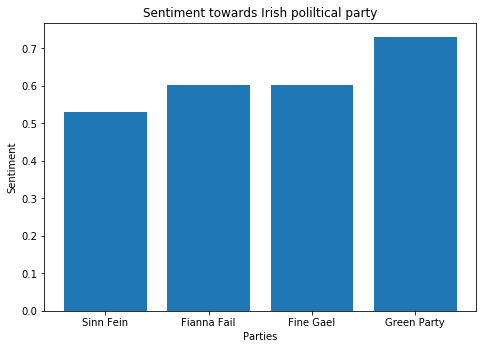

In [60]:
support =[sf_df['sf_scores'].mean(),ff_df['ff_scores'].mean(),fg_df['fg_scores'].mean(),gp_df['gp_scores'].mean()]
parties = ['Sinn Fein','Fianna Fail','Fine Gael', 'Green Party']

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(parties,support)
plt.title("Sentiment towards Irish poliltical party")
plt.xlabel('Parties')
plt.ylabel('Sentiment')
plt.show()

In [61]:
ff_df['ff_scores'].mean()

0.6026840189594357

In [62]:
gov_dict = scrape_comment_data(reddit,"Irish government",limit=100)
gov_df = pd.DataFrame.from_dict(gov_dict)
gov_df['comments_no_stops'] = gov_df['comments'].apply(lambda text:" ".join(remove_stops(text)))
gov_df["comments_lemmatized"] = gov_df['comments_no_stops'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x)]))

gov_df['gp_scores'] = gov_df['comments_lemmatized'].apply(lambda comments: positivity(comments,"green party"))
gov_df['fg_scores'] = gov_df['comments_lemmatized'].apply(lambda comments: positivity(comments,"fine gael"))

gov_df['ff_scores'] = gov_df['comments_lemmatized'].apply(lambda comments: positivity(comments,"fianna fail"))
gov_df['sf_scores'] = gov_df['comments_lemmatized'].apply(lambda comments: positivity(comments,"sinn fein"))

gov_df['gp_scores'] = gov_df['gp_scores'].apply(lambda score: (score+1)/2)
gov_df['fg_scores'] = gov_df['fg_scores'].apply(lambda score: (score+1)/2)

gov_df['ff_scores'] = gov_df['ff_scores'].apply(lambda score: (score+1)/2)
gov_df['sf_scores'] = gov_df['sf_scores'].apply(lambda score: (score+1)/2)



In [67]:
gov_support =[   gov_df['sf_scores'].mean(),
    gov_df['ff_scores'].mean(),
    gov_df['fg_scores'].mean(),
    gov_df['gp_scores'].mean()

]

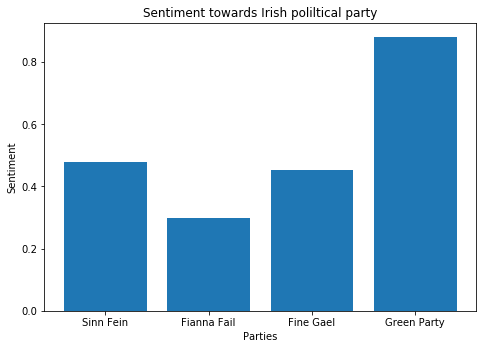

In [68]:
parties = ['Sinn Fein','Fianna Fail','Fine Gael', 'Green Party']

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(parties,gov_support)
plt.title("Sentiment towards Irish poliltical party")
plt.xlabel('Parties')
plt.ylabel('Sentiment')
plt.show()